# CCPU Forecasting 

## Import Libraraies 

In [89]:
pip install pandas  matplotlib


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [90]:
import pandas as pd
import matplotlib.pyplot as plt

In [91]:
data = pd.read_csv("Challenge_CPU_prediction/Data/cpu_usage.csv")
data.head(10)

,server_id,Date,Timestamp,service_id,service_description,CPU_percent
0,252705,22-11-2025,22-11-2025 20:30,677,CPU_Usage,0.000433
1,179768,28-10-2025,28-10-2025 14:00,438,CPU_Usage,0.000833
2,252705,11-10-2025,11-10-2025 20:30,677,CPU_Usage,0.000833
3,638939,15-10-2025,15-10-2025 00:30,565,CPU_Usage,0.001250
4,638939,26-9-2025,26-9-2025 08:30,565,CPU_Usage,0.001689
5,187782,9-10-2025,9-10-2025 05:00,2710,CPU_Usage,0.001694
6,179768,12-10-2025,12-10-2025 04:30,438,CPU_Usage,0.001722
7,252944,27-11-2025,27-11-2025 16:00,7087,CPU_Usage,0.001750
8,252705,27-10-2025,27-10-2025 11:00,677,CPU_Usage,0.002167
9,115330,29-11-2025,29-11-2025 05:00,416,CPU_Usage,0.002222


## Wrangling

/var/folders/5h/zq5wwpvd123278t5ckn5zdn80000gn/T/ipykernel_38531/1240434822.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Timestamp"] = pd.to_datetime(data["Timestamp"])


delta_minutes
0.0       661699
30.0        5857
360.0        424
1440.0       105
1350.0         1
Name: count, dtype: int64
['CPU_Usage' 'Windows_CPU_Usage' 'CPU_Usage_SQL']
[252705 179768 638939 187782 252944 115330 257258 590668 800191 839463
 310738 706080 161661 355619 880645 713350 830824 253947 166665 112121
 345910 100595 209976 440056 884512 768545 979441 498343 324449 656359
 101895 909077 961541 328350 807952 410631 469745 430803 698994 408479
 441914 519142 494963 142261 382543 364448 500252 248604 917172 513757
 150495 641833 647454 553291 788300 269228 484302 374215 395512 272243
 965874 814272 517748 748539 511495 298408 751668 536144 688159 185228
 349609 501656 543451 713900 285818 203627 493447 647171 630826 319271
 725736 378001 835801 477128 293055 585673 488224 803361 451677 792934
 467230 602004 703045 892329 501565 223463 852865 768393 217456 545838
 747220 662930 507499 771083 871762 629045 704105 519057 435626 830369
 566140 809089 698972 159159 535689 256132 2

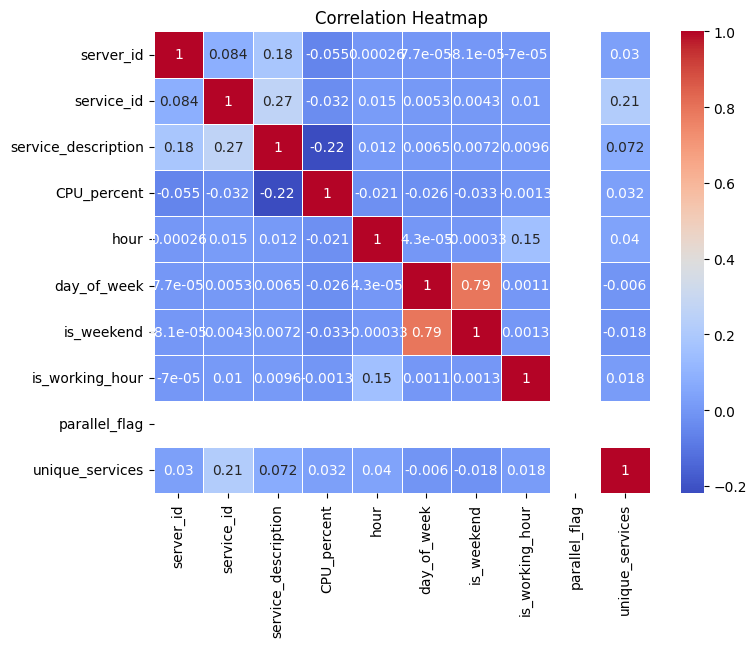

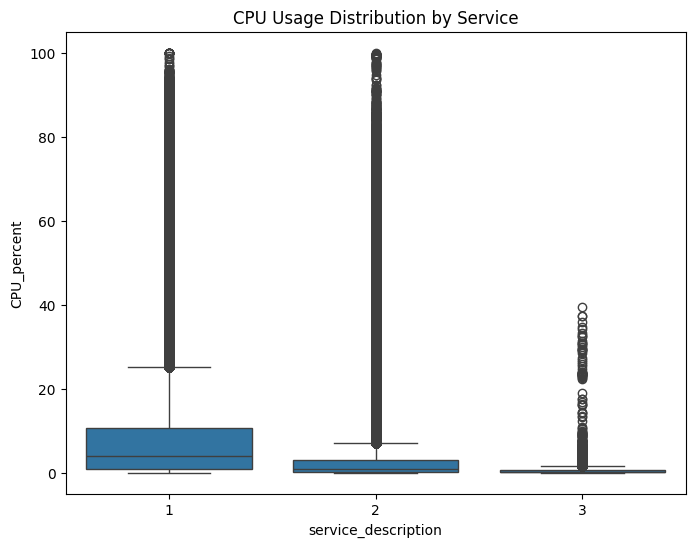

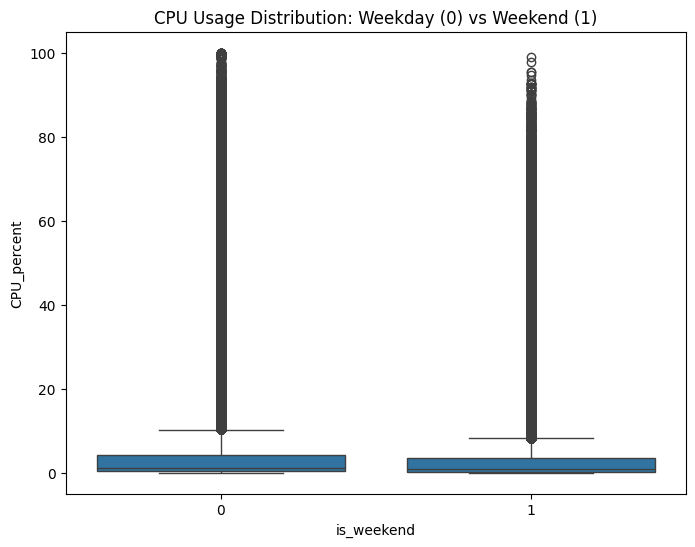

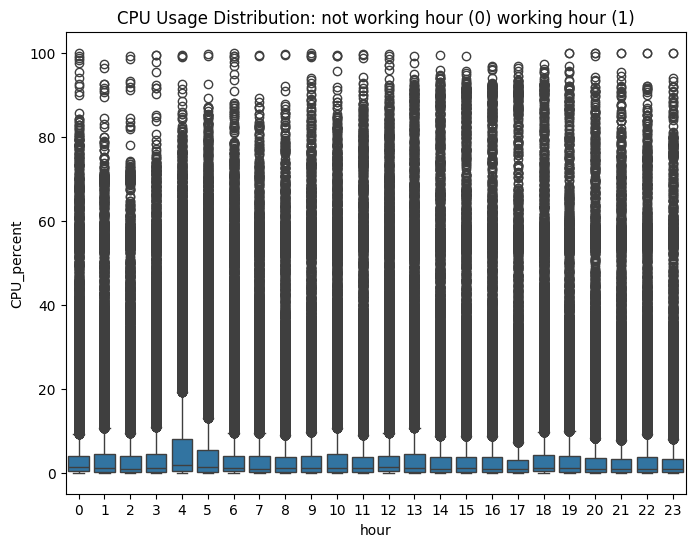

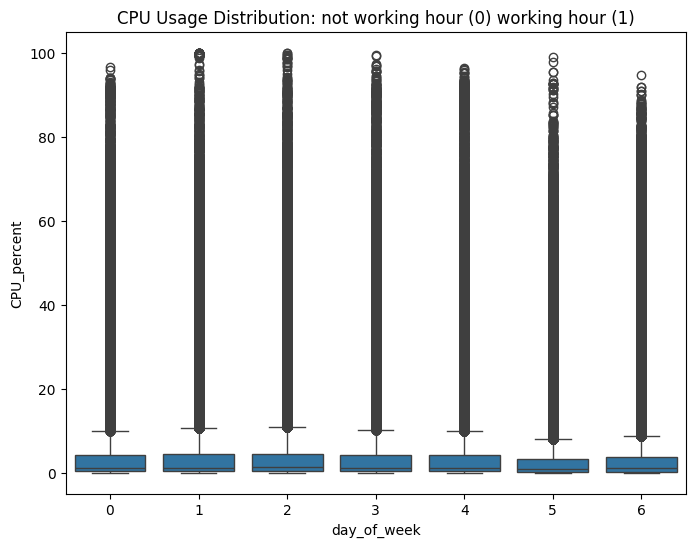

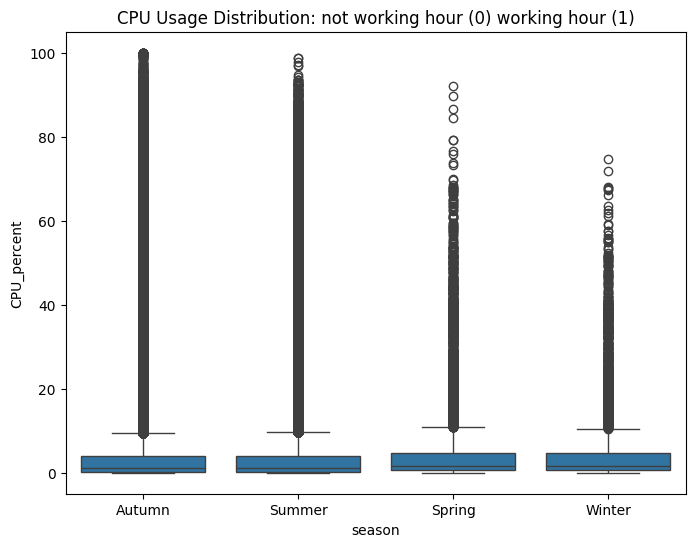

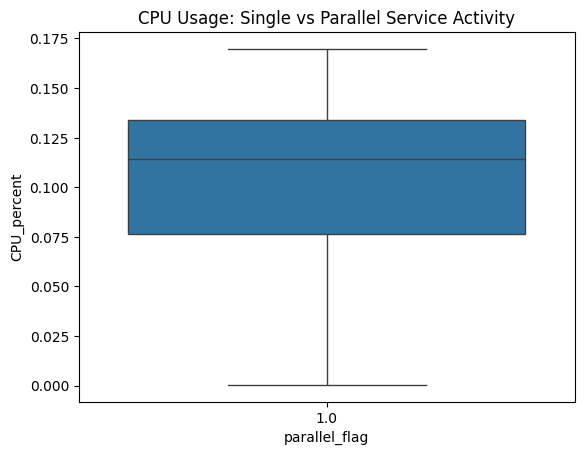

parallel_flag
1.0    6388
Name: count, dtype: int64


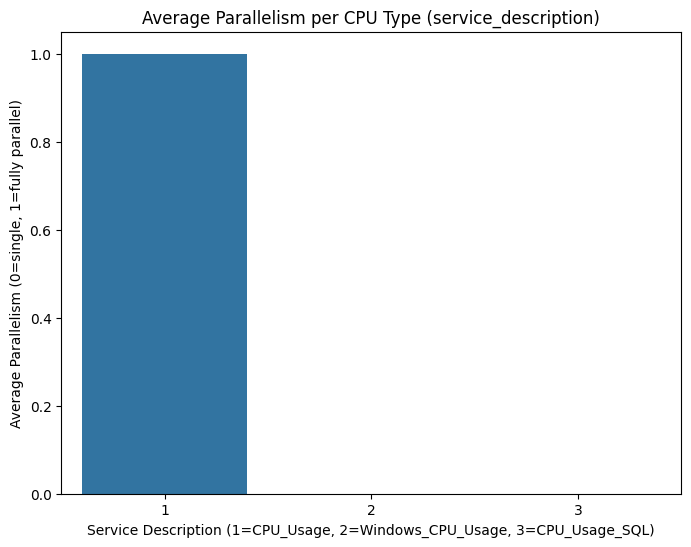

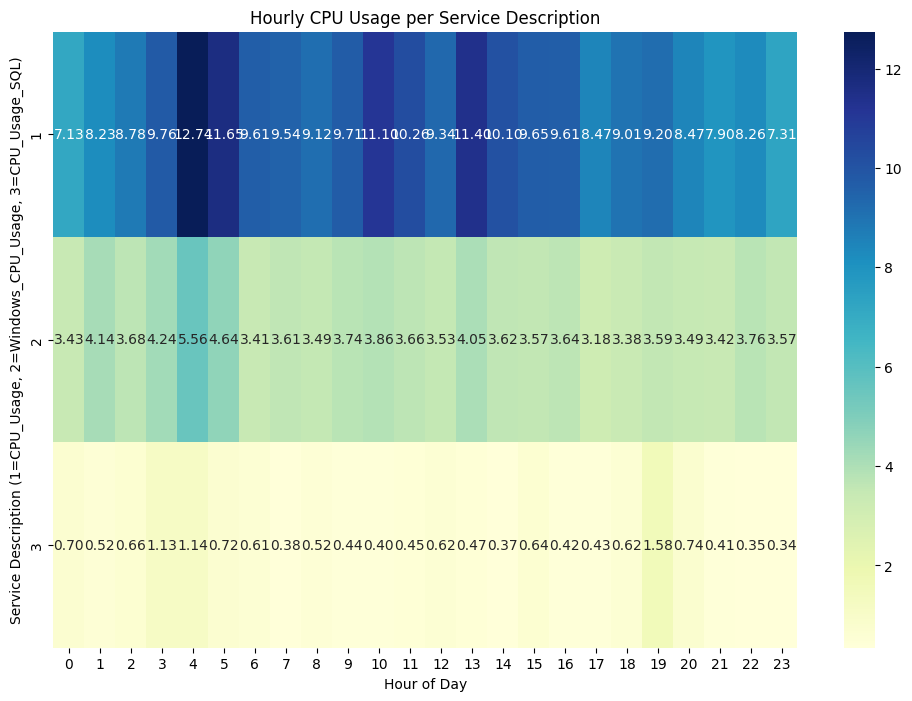

   service_description  avg_parallelism  row_count
0                    1              1.0       6388
1                    2              NaN          0
2                    3              NaN          0


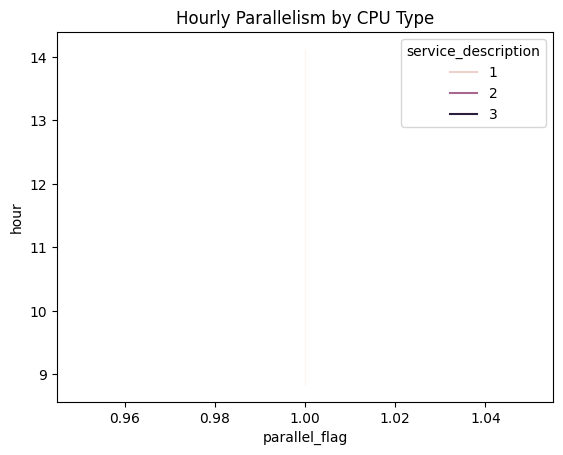

Duplication : 0
Values Counts : Timestamp
2025-11-30 23:00:00    1
2025-01-01 00:00:00    1
2025-01-01 00:30:00    1
2025-01-01 01:00:00    1
2025-01-01 01:30:00    1
Name: count, dtype: int64


,Timestamp,CPU_percent,parallel_flag,unique_services,hour,day_of_week,week,month,is_weekend,CPU_lag1,CPU_lag2,CPU_roll_mean,CPU_target
0,2025-01-01 00:00:00,3.762789,NaN,94.0,0,2,1,1,0,NaN,NaN,NaN,NaN
1,2025-01-01 00:30:00,NaN,NaN,NaN,0,2,1,1,0,3.762789,NaN,NaN,NaN
2,2025-01-01 01:00:00,NaN,NaN,NaN,1,2,1,1,0,NaN,3.762789,NaN,NaN
3,2025-01-01 01:30:00,NaN,NaN,NaN,1,2,1,1,0,NaN,NaN,NaN,NaN
4,2025-01-01 02:00:00,NaN,NaN,NaN,2,2,1,1,0,NaN,NaN,NaN,NaN
5,2025-01-01 02:30:00,NaN,NaN,NaN,2,2,1,1,0,NaN,NaN,NaN,NaN
6,2025-01-01 03:00:00,NaN,NaN,NaN,3,2,1,1,0,NaN,NaN,NaN,NaN
7,2025-01-01 03:30:00,NaN,NaN,NaN,3,2,1,1,0,NaN,NaN,NaN,NaN
8,2025-01-01 04:00:00,NaN,NaN,NaN,4,2,1,1,0,NaN,NaN,NaN,NaN
9,2025-01-01 04:30:00,NaN,NaN,NaN,4,2,1,1,0,NaN,NaN,NaN,NaN


In [136]:
def Wrangling(df):
    data = df[["server_id", "Timestamp", "service_id", "service_description", "CPU_percent"]]

    data["Timestamp"] = pd.to_datetime(data["Timestamp"])    

    
    # Convert to datetime
    df["Timestamp"] = pd.to_datetime(df["Timestamp"], dayfirst=True)

    # Check timestamp interval 
    # Sort by time
    df = df.sort_values("Timestamp")
    
    # Compute differences
    df["delta"] = df["Timestamp"].diff()
    
    # Convert to minutes
    df["delta_minutes"] = df["delta"].dt.total_seconds() / 60
    
    print(df["delta_minutes"].value_counts().head(10))

    # Count how many services per timestamp
    service_counts = (
        df.groupby("Timestamp")["service_id"]
          .nunique()
          .reset_index(name="unique_services")
    )


    # Show a few examples
    data["parallel_flag"] = (service_counts["unique_services"] > 1).astype(int)
    data = data.merge(service_counts, on="Timestamp", how="left")

    
    data["hour"] = data["Timestamp"].dt.hour
    data["day"] = data["Timestamp"].dt.day
    data["day_of_week"] = data["Timestamp"].dt.dayofweek 
    data["month"] = data["Timestamp"].dt.month
    data["is_weekend"] = data["day_of_week"].isin([5, 6]).astype(int)
    # Add working hour flag (1 = working hours, 0 = non-working hours)
    data["is_working_hour"] = data["hour"].between(8, 17).astype(int)

        # --- Add seasons (Northern Hemisphere convention) ---
    def get_season(month):
        if month in [12, 1, 2]:
            return "Winter"
        elif month in [3, 4, 5]:
            return "Spring"
        elif month in [6, 7, 8]:
            return "Summer"
        else:
            return "Autumn"
    
    data["season"] = data["month"].apply(get_season)
    
        

    print(data["service_description"].unique())
    print(data["server_id"].unique())
    print("-------------------- data length ----------------")
    print("length general data:\n", len(data))
    print("length of server_id:\n", len(data["server_id"].unique()))
    print("length of service_id:\n", len(data["service_id"].unique()))
    print("--------------------- Different Group By ------------- ")
    print("service_description group by Cpu percent")
    grouped = data.groupby("service_description")["CPU_percent"].mean().reset_index()
    print("Average CPU usage per service:\n", grouped)
    print("-------------- Check Missing Values for each column --------------")
    for col in data.columns:
        missing_count = data[col].isnull().sum()
        print(f"{col}: {missing_count} missing values")
     
    data = data[["server_id", "Timestamp", "service_id", "service_description", "CPU_percent", "hour", "day_of_week", "is_weekend", "is_working_hour", "season", "parallel_flag", "unique_services"]].copy()
    
    service_description_mapping = {
        "CPU_Usage": 1,
        "Windows_CPU_Usage": 2,
        "CPU_Usage_SQL": 3
    }
    
    data["service_description"] = data["service_description"].map(service_description_mapping)
    print("Service description \n", data[data["service_description"] == 2])
    
    # --- Correlation Heatmap ---
    numeric_data = data.select_dtypes(include=["number"])
    corr = numeric_data.corr()
    
    plt.figure(figsize=(8,6))
    sns.heatmap(corr, annot=True, cmap="coolwarm", linewidths=0.5)
    plt.title("Correlation Heatmap")
    plt.show()
    
    # --- Boxplot (Boîte Moustache) ---
    plt.figure(figsize=(8,6))
    sns.boxplot(x="service_description", y="CPU_percent", data=data)
    plt.title("CPU Usage Distribution by Service")
    plt.show()
    
    # --- Boxplot by Weekend vs Weekday ---
    plt.figure(figsize=(8,6))
    sns.boxplot(x="is_weekend", y="CPU_percent", data=data)
    plt.title("CPU Usage Distribution: Weekday (0) vs Weekend (1)")
    plt.show()

    # --- Boxplot by Weekend vs Weekday ---
    plt.figure(figsize=(8,6))
    sns.boxplot(x="hour", y="CPU_percent", data=data)
    plt.title("CPU Usage Distribution: not working hour (0) working hour (1)")
    plt.show()

    plt.figure(figsize=(8,6))
    sns.boxplot(x="day_of_week", y="CPU_percent", data=data)
    plt.title("CPU Usage Distribution: not working hour (0) working hour (1)")
    plt.show()
            # Create combined category

    plt.figure(figsize=(8,6))
    sns.boxplot(x="season", y="CPU_percent", data=data)
    plt.title("CPU Usage Distribution: not working hour (0) working hour (1)")
    plt.show()

    sns.boxplot(x="parallel_flag", y="CPU_percent", data=data)
    plt.title("CPU Usage: Single vs Parallel Service Activity")
    plt.show()
    

    print(data["parallel_flag"].value_counts())

    # Step 1: Group by service_description and compute average parallel_flag
    parallel_summary = (
        data.groupby("service_description")["parallel_flag"]
        .mean()
        .reset_index(name="avg_parallelism")
    )
    
    # Step 2: Plot it
    plt.figure(figsize=(8,6))
    sns.barplot(x="service_description", y="avg_parallelism", data=parallel_summary)
    plt.title("Average Parallelism per CPU Type (service_description)")
    plt.xlabel("Service Description (1=CPU_Usage, 2=Windows_CPU_Usage, 3=CPU_Usage_SQL)")
    plt.ylabel("Average Parallelism (0=single, 1=fully parallel)")
    plt.ylim(0, 1.05)
    plt.show()


    # Pivot by service_description instead of service_id
    pivot = data.pivot_table(
        index="service_description",   # <-- use service_description (1, 2, 3)
        columns="hour",
        values="CPU_percent",
        aggfunc="mean"
    )
    
    plt.figure(figsize=(12,8))
    sns.heatmap(pivot, cmap="YlGnBu", annot=True, fmt=".2f")
    plt.title("Hourly CPU Usage per Service Description")
    plt.xlabel("Hour of Day")
    plt.ylabel("Service Description (1=CPU_Usage, 2=Windows_CPU_Usage, 3=CPU_Usage_SQL)")
    plt.show()




    parallel_summary = (
        data.groupby("service_description")["parallel_flag"]
        .mean()
        .reset_index(name="avg_parallelism")
    )
    
    parallel_summary["row_count"] = data.groupby("service_description")["parallel_flag"].count().values
    print(parallel_summary)


    time_parallel = (
        data.groupby(["hour","service_description"])["parallel_flag"]
        .mean()
        .reset_index()
    )
    
    sns.lineplot(x="parallel_flag", y="hour", hue="service_description", data=time_parallel)
    plt.title("Hourly Parallelism by CPU Type")
    plt.show()

    
    # --- Resample to 30-minute bins for predictive modeling ---
    df = data.set_index("Timestamp")
    data_30min = (
        df.resample("30min")
        .agg({
            "CPU_percent": "mean",          # average CPU usage in the bin
            "parallel_flag": "max",         # mark as parallel if any service was parallel
            "unique_services": "max"        # max services active in the bin
        })
        .reset_index()
    )

    # --- Time features ---
    data_30min["hour"] = data_30min["Timestamp"].dt.hour
    data_30min["day_of_week"] = data_30min["Timestamp"].dt.dayofweek
    data_30min["week"] = data_30min["Timestamp"].dt.isocalendar().week
    data_30min["month"] = data_30min["Timestamp"].dt.month
    data_30min["is_weekend"] = data_30min["day_of_week"].isin([5, 6]).astype(int)

    # --- Lag features and rolling stats ---
    data_30min["CPU_lag1"] = data_30min["CPU_percent"].shift(1)
    data_30min["CPU_lag2"] = data_30min["CPU_percent"].shift(2)
    data_30min["CPU_roll_mean"] = data_30min["CPU_percent"].rolling(3).mean()

    # --- Target: next 30-min CPU usage ---
    data_30min["CPU_target"] = data_30min["CPU_percent"].shift(-1)

    # Replace your final return with this dataset

    print("Duplication :", data_30min["Timestamp"].duplicated().sum())

    # Hour and is week_end and is day all this by description of service .
    print("Values Counts :", data_30min["Timestamp"].value_counts().head())

    return data_30min
    

wrangled_data = Wrangling(data)
wrangled_data.head(10)

## Visualisations 

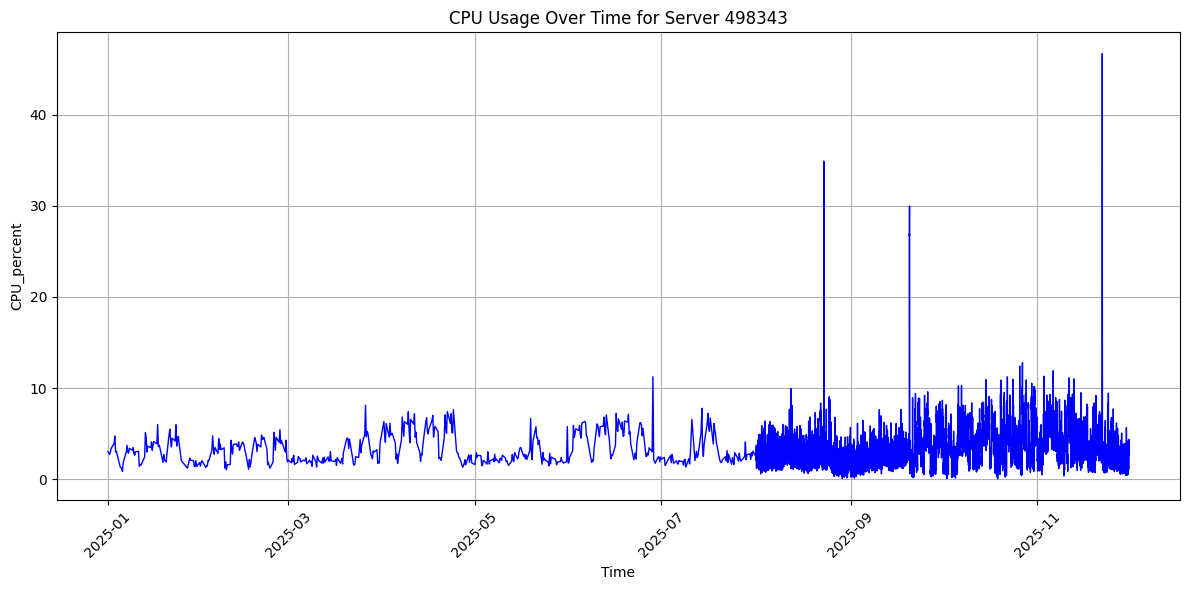

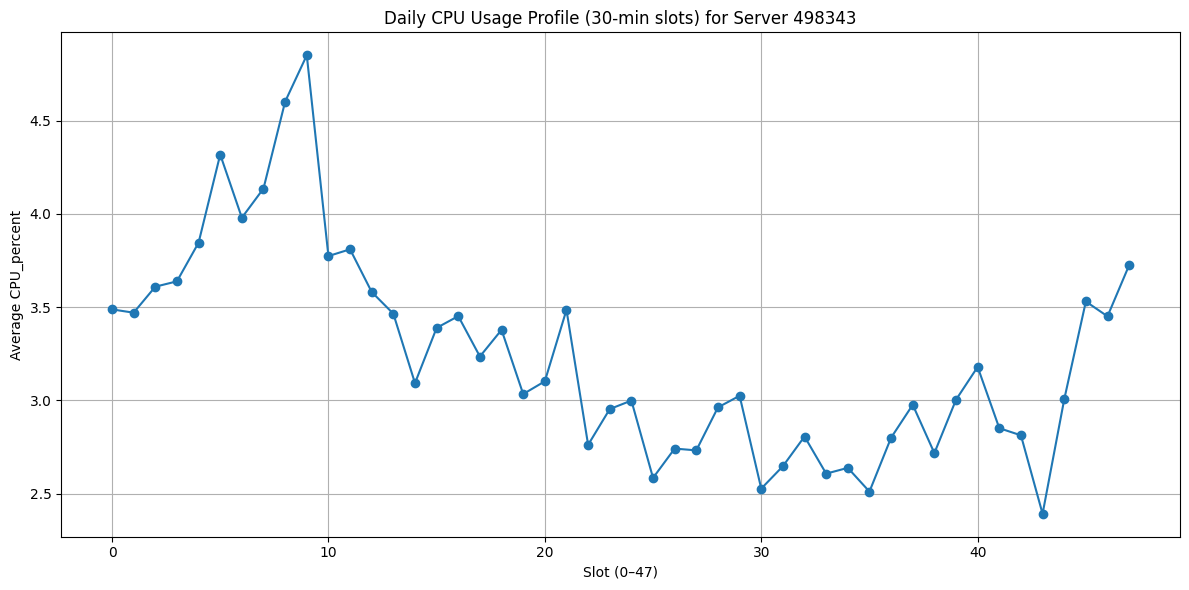

In [97]:
def Visualisations(df):
    # 1. Select a sample server (first one in the dataset)
    sample_server_id = 498343
    sample_df = wrangled_data[wrangled_data["server_id"] == sample_server_id].copy()
    
    # 2. Plot CPU% over time for that server
    # Sort by Timestamp to ensure smooth line
    sample_df = sample_df.sort_values("Timestamp")
    
    # Plot CPU% over time as a proper line chart
    plt.figure(figsize=(12,6))
    plt.plot(sample_df["Timestamp"], sample_df["CPU_percent"], color="blue", linewidth=1)
    plt.title(f"CPU Usage Over Time for Server {sample_server_id}")
    plt.xlabel("Time")
    plt.ylabel("CPU_percent")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    
    # 3. Compute daily profile (30-min slots)
    sample_df["slot"] = sample_df["Timestamp"].dt.hour * 2 + (sample_df["Timestamp"].dt.minute // 30)
    
    daily_profile = sample_df.groupby("slot")["CPU_percent"].mean().reset_index()
    
    # 4. Plot daily profile=--
    plt.figure(figsize=(12,6))
    plt.plot(daily_profile["slot"], daily_profile["CPU_percent"], marker="o")
    plt.title(f"Daily CPU Usage Profile (30-min slots) for Server {sample_server_id}")
    plt.xlabel("Slot (0–47)")
    plt.ylabel("Average CPU_percent")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Visualisations(wrangled_data)
